<a href="https://colab.research.google.com/github/claudio1975/SWISSTEXT_2022/blob/main/NLP_text_classification_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP_&_INSURANCE: TEXT_CLASSIFICATION**

![](https://www.babel.sg/wp-content/uploads/2019/11/Insurance-Recommendation-System-Increased-Customer-Conversion-Engagement-Rate.png)

## Import Libraries

In [1]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 42.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━

In [2]:
#setup deterministic results 
import numpy as np
from numpy.random import seed
seed=0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import re
import string
#import langdetect 
import ktrain
from ktrain import text
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec 
import gensim.downloader as gensim_api
#from bertopic import BERTopic

## Requirements

In [3]:
print(np.__version__) 

1.21.6


In [4]:
print(pd.__version__) 

1.3.5


In [5]:
print(sklearn.__version__)

1.0.2


In [6]:
print(sns.__version__)

0.11.2


In [7]:
print(tf.__version__)

2.9.2


In [8]:
print(spacy.__version__)

3.4.4


In [9]:
print(gensim.__version__)

3.6.0


In [10]:
print(ktrain.__version__)

0.33.0


## Upload dataset

In [11]:
# https://www.kaggle.com/competitions/nlp-getting-started

In [12]:
df_train = pd.read_csv('https://raw.githubusercontent.com/claudio1975/SWISSTEXT_2022/main/data/df_train.csv')

In [13]:
#from google.colab import files 
#uploaded = files.upload() 

In [14]:
# Reading File
#df_train = pd.read_csv('df_train.csv')

In [15]:
# select columns
df_4 = df_train.iloc[:,1:8]
df_4.head()

,id,keyword,location,text,target,lang,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,deeds reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,en,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,en,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en,get send photo ruby alaska smoke wildfires pou...


## Prepare Data sets

In [16]:
train_docs = df_4.copy()

In [17]:
train_docs = train_docs[['text','target']]
train_docs.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
classification = {1:'disaster',0:'not_disaster'}
train_docs['classification'] = train_docs['target'].map(classification)
train_docs_ = train_docs[['text','classification']]
# split target variable
y = train_docs_['classification']
train_docs_.head()

,text,classification
0,Our Deeds are the Reason of this #earthquake M...,disaster
1,Forest fire near La Ronge Sask. Canada,disaster
2,All residents asked to 'shelter in place' are ...,disaster
3,"13,000 people receive #wildfires evacuation or...",disaster
4,Just got sent this photo from Ruby #Alaska as ...,disaster


In [19]:
def tt_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) 
    o = np.random.permutation(X.shape[0])
    
    X_train, X_test = np.split(np.take(X,o,axis=0), [i])
    y_train, y_test = np.split(np.take(y,o), [i])
    return X_train, X_test, y_train, y_test

In [20]:
X_train_, X_test, y_train_, y_test = tt_split(train_docs_,y)

In [21]:
X_train_

,text,classification
311,@KatieKatCubs you already know how this shit g...,not_disaster
4970,@LeMaireLee @danharmon People Near Meltdown Co...,not_disaster
527,1-6 TIX Calgary Flames vs COL Avalanche Presea...,not_disaster
6362,If you ever think you running out of choices i...,not_disaster
800,If you dotish to blight your car go right ahea...,not_disaster
...,...,...
6647,@SwiftyCommissh @TaoistInsight @ImmortalTech S...,disaster
6031,Thanks Benson &amp; Clegg for the #follow! Che...,not_disaster
239,ANNIHILATED IN DAMASCUS: SYRIAN ARMY GRINDS Û...,disaster
5720,VIDEO: 'We're picking up bodies from water': R...,disaster


In [22]:
X_test

,text,classification
542,The possible new jerseys for the Avalanche nex...,not_disaster
2725,ÛÏRichmond Coaches were devastated to hear of...,disaster
2454,Madhya Pradesh Train Derailment: Village Youth...,disaster
1459,Small casualty on the way to Colorado http://t...,disaster
5764,'Without an ally near you can't use this skill...,not_disaster
...,...,...
4931,They are the real heroes... RIP Brave hearts.....,not_disaster
3264,Car engulfed in flames backs up traffic at Par...,disaster
1653,Great British Bake Off's back and Dorret's cho...,disaster
2607,Black Eye 9: A space battle occurred at Star O...,not_disaster


In [23]:
(x_train, y_train), (x_val, y_val), preproc = text.texts_from_df(train_df = X_train_, 
                                                                   text_column = 'text',
                                                                   label_columns=['classification'],
                                                                   maxlen=100, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.2)


['disaster', 'not_disaster']
      disaster  not_disaster
6374       1.0           0.0
6503       0.0           1.0
1988       0.0           1.0
4173       0.0           1.0
1699       0.0           1.0
['disaster', 'not_disaster']
      disaster  not_disaster
2844       1.0           0.0
6691       1.0           0.0
1746       0.0           1.0
6134       0.0           1.0
5757       0.0           1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## Modelling with BERT




In [24]:
model_BERT = text.text_classifier(name='bert', train_data = (x_train, y_train) , preproc=preproc)

Is Multi-Label? False
maxlen is 100
done.


In [25]:
learner_BERT = ktrain.get_learner(model = model_BERT, 
                             train_data=(x_train, y_train), 
                             val_data=(x_val, y_val), 
                             batch_size=32, 
                             use_multiprocessing = True)


In [26]:
learner_BERT.fit_onecycle(lr=2e-5, epochs=1,checkpoint_folder='output')



begin training using onecycle policy with max lr of 2e-05...
153/153 [==============================] - 139s 770ms/step - loss: 0.5086 - accuracy: 0.7562 - val_loss: 0.3948 - val_accuracy: 0.8415


In [27]:
predictor_BERT = ktrain.get_predictor(learner_BERT.model, preproc)

In [28]:
learner_BERT.print_layers()

0 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7fb80a3767c0>
1 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7fb80a38cd30>
2 (trainable=True) : <keras_bert.layers.embedding.TokenEmbedding object at 0x7fb80a376790>
3 (trainable=True) : <keras.layers.core.embedding.Embedding object at 0x7fb7f481f0a0>
4 (trainable=True) : <keras.layers.merging.add.Add object at 0x7fb7f4b0fca0>
5 (trainable=True) : <keras_pos_embd.pos_embd.PositionEmbedding object at 0x7fb7f07a7820>
6 (trainable=True) : <keras.layers.regularization.dropout.Dropout object at 0x7fb7f0787910>
7 (trainable=True) : <keras_layer_normalization.layer_normalization.LayerNormalization object at 0x7fb7f0787c40>
8 (trainable=True) : <keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x7fb7f06b6df0>
9 (trainable=True) : <keras.layers.regularization.dropout.Dropout object at 0x7fb7f06b67f0>
10 (trainable=True) : <keras.layers.merging.add.Add object at 0x7fb7f064c1c0>
11 (trai

In [29]:
pred_tweets_train_BERT = predictor_BERT.predict(X_train_.text.values)
pred_tweets_train_BERT = pd.DataFrame(data=pred_tweets_train_BERT, columns=['predicted_label_train'])

191/191 [==============================] - 46s 221ms/step


In [30]:
pred_tweets_test_BERT = predictor_BERT.predict(X_test.text.values)
pred_tweets_test_BERT = pd.DataFrame(data=pred_tweets_test_BERT, columns=['predicted_label_test'])

48/48 [==============================] - 10s 218ms/step


In [31]:
accuracy_tweets_train_BERT = accuracy_score(y_train_, pred_tweets_train_BERT) 
accuracy_tweets_test_BERT = accuracy_score(y_test, pred_tweets_test_BERT)      

In [32]:
F1_tweets_train_BERT = f1_score(y_train_, pred_tweets_train_BERT, average='weighted') 
F1_tweets_test_BERT = f1_score(y_test, pred_tweets_test_BERT,average='weighted') 

In [33]:
d1 = {'metrics': ['Accuracy', 'F1_score'],
     'model': ['BERT_by_ktrain','BERT_by_ktrain'],
    'train': [accuracy_tweets_train_BERT,F1_tweets_train_BERT],
    'test': [accuracy_tweets_test_BERT,F1_tweets_test_BERT]}
df1 = pd.DataFrame(data=d1, columns=['model','metrics','train','test'])
print('Metrics on disaster classification')
df1

Metrics on disaster classification


,model,metrics,train,test
0,BERT_by_ktrain,Accuracy,0.853530,0.821405
1,BERT_by_ktrain,F1_score,0.853102,0.820450


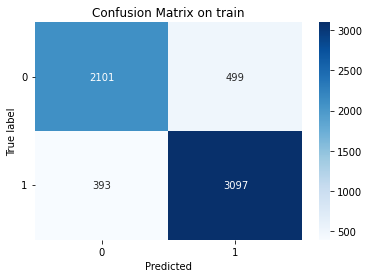

In [34]:
# Plot confusion matrix
cm = confusion_matrix(y_train_, pred_tweets_train_BERT)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on train")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

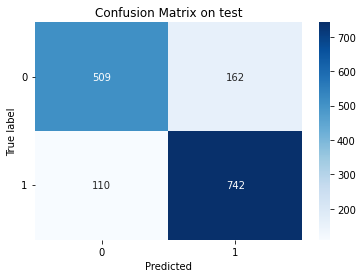

In [35]:
# Plot confusion matrix
cm = confusion_matrix(y_test, pred_tweets_test_BERT)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on test")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show() 

## Inference on BERT Modelling

In [36]:
pd.set_option('display.max_colwidth', None)

In [37]:
predictor_BERT.predict("The possible new jerseys for the Avalanche next year. ????")

1/1 [==============================] - 0s 41ms/step


'not_disaster'

In [38]:
X_test.loc[542,:]

text              The possible new jerseys for the Avalanche next year. ???? http://t.co/nruzhR5XQu
classification                                                                         not_disaster
Name: 542, dtype: object

In [39]:
predictor_BERT.predict('Car engulfed in flames backs up traffic at Parleys Summit ?')

1/1 [==============================] - 0s 33ms/step


'disaster'

In [40]:
X_test.loc[3264,:]

text              Car engulfed in flames backs up traffic at ParleyÛªs Summit http://t.co/RmucfjCaZr
classification                                                                               disaster
Name: 3264, dtype: object

In [41]:
predictor_BERT.predict("Small casualty on the way to Colorado")

1/1 [==============================] - 0s 34ms/step


'disaster'

In [42]:
X_test.loc[1459,:]

text              Small casualty on the way to Colorado http://t.co/hDVmhSQXHm
classification                                                        disaster
Name: 1459, dtype: object

In [43]:
predictor_BERT.predict("Bicycle-SUV accident in Mesick: Police say that the bicyclist entered onto West M-115 and collided with a boat...")

1/1 [==============================] - 0s 31ms/step


'disaster'

In [44]:
X_test.loc[1730,:]

text              Bicycle-SUV accident in Mesick: Police say that the bicyclist entered onto West M-115 and collided with a boat... http://t.co/A9gtOPyZK8
classification                                                                                                                                    disaster
Name: 1730, dtype: object

In [45]:
predictor_BERT.predict('Oil prices falling but drivers could reap benefits')

1/1 [==============================] - 0s 35ms/step


'not_disaster'

In [46]:
X_test.loc[1903,:]

text              Oil prices falling but drivers could reap benefits http://t.co/QlTwhoJqYA
classification                                                                 not_disaster
Name: 1903, dtype: object

## Modelling with Logistic Regression




In [47]:
(x_tr, y_tr), (x_vl, y_vl), preproc = text.texts_from_df(train_df = X_train_, 
                                                                   text_column = 'text',
                                                                   label_columns=['classification'],
                                                                   maxlen=100, 
                                                                   max_features=100000,
                                                                   preprocess_mode='standard',
                                                                   val_pct=0.2)

['disaster', 'not_disaster']
      disaster  not_disaster
1627       1.0           0.0
716        0.0           1.0
1171       1.0           0.0
7535       1.0           0.0
7249       0.0           1.0
['disaster', 'not_disaster']
      disaster  not_disaster
4951       0.0           1.0
1386       0.0           1.0
7583       1.0           0.0
251        1.0           0.0
4008       1.0           0.0
language: en
Word Counts: 16585
Nrows: 4872
4872 train sequences
train sequence lengths:
	mean : 17
	95percentile : 25
	99percentile : 28
x_train shape: (4872,100)
y_train shape: (4872, 2)
Is Multi-Label? False
1218 test sequences
test sequence lengths:
	mean : 14
	95percentile : 23
	99percentile : 26
x_test shape: (1218,100)
y_test shape: (1218, 2)


In [48]:
model_LR = text.text_classifier(name='logreg', train_data = (x_tr, y_tr) , preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 100
done.


In [49]:
learner_LR = ktrain.get_learner(model = model_LR, 
                             train_data=(x_tr, y_tr), 
                             val_data=(x_vl, y_vl))


In [50]:
learner_LR.fit(lr=2e-5, n_cycles=1)

153/153 [==============================] - 1s 5ms/step - loss: 0.6906 - accuracy: 0.5757 - val_loss: 0.6888 - val_accuracy: 0.6018


In [51]:
predictor_LR = ktrain.get_predictor(learner_LR.model, preproc)

In [52]:
learner_LR.print_layers()

0 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7fb76a0fbd30>
1 (trainable=True) : <keras.layers.core.embedding.Embedding object at 0x7fb76a0fb9a0>
2 (trainable=False) : <keras.layers.core.embedding.Embedding object at 0x7fb76a0fb940>
3 (trainable=True) : <keras.layers.merging.dot.Dot object at 0x7fb76a0fbc10>
4 (trainable=True) : <keras.layers.reshaping.flatten.Flatten object at 0x7fb76a1616a0>
5 (trainable=True) : <keras.layers.core.activation.Activation object at 0x7fb76a161730>


In [53]:
pred_tweets_train_LR = predictor_LR.predict(X_train_.text.values)
pred_tweets_train_LR = pd.DataFrame(data=pred_tweets_train_LR, columns=['predicted_label_train'])

191/191 [==============================] - 0s 1ms/step


In [54]:
pred_tweets_test_LR = predictor_LR.predict(X_test.text.values)
pred_tweets_test_LR = pd.DataFrame(data=pred_tweets_test_LR, columns=['predicted_label_test'])

48/48 [==============================] - 0s 1ms/step


In [55]:
accuracy_tweets_train_LR = accuracy_score(y_train_, pred_tweets_train_LR) 
accuracy_tweets_test_LR = accuracy_score(y_test, pred_tweets_test_LR)      

In [56]:
F1_tweets_train_LR = f1_score(y_train_, pred_tweets_train_LR, average='weighted') 
F1_tweets_test_LR = f1_score(y_test, pred_tweets_test_LR,average='weighted') 

In [57]:
d2 = {'metrics': ['Accuracy', 'F1_score'],
     'model': ['LR_by_ktrain','LR_by_ktrain'],
    'train': [accuracy_tweets_train_LR,F1_tweets_train_LR],
    'test': [accuracy_tweets_test_LR,F1_tweets_test_LR]}
df2 = pd.DataFrame(data=d2, columns=['model','metrics','train','test'])
print('Metrics on disaster classification')
df2

Metrics on disaster classification


,model,metrics,train,test
0,LR_by_ktrain,Accuracy,0.628900,0.586999
1,LR_by_ktrain,F1_score,0.629975,0.586999


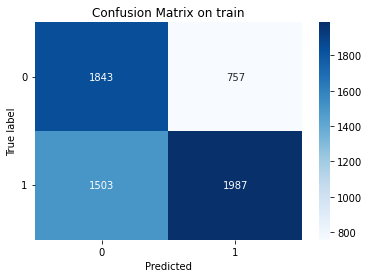

In [58]:
# Plot confusion matrix
cm = confusion_matrix(y_train_, pred_tweets_train_LR)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on train")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

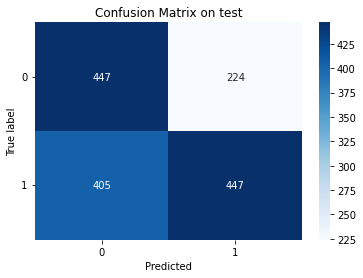

In [59]:
# Plot confusion matrix
cm = confusion_matrix(y_test, pred_tweets_test_LR)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on test")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show() 

## Inference on Logistic Regression Modelling

In [60]:
pd.set_option('display.max_colwidth', None)

In [61]:
predictor_LR.predict("The possible new jerseys for the Avalanche next year. ????")

1/1 [==============================] - 0s 21ms/step


'not_disaster'

In [62]:
X_test.loc[542,:]

text              The possible new jerseys for the Avalanche next year. ???? http://t.co/nruzhR5XQu
classification                                                                         not_disaster
Name: 542, dtype: object

In [63]:
predictor_LR.predict('Car engulfed in flames backs up traffic at Parleys Summit ?')

1/1 [==============================] - 0s 19ms/step


'not_disaster'

In [64]:
X_test.loc[3264,:]

text              Car engulfed in flames backs up traffic at ParleyÛªs Summit http://t.co/RmucfjCaZr
classification                                                                               disaster
Name: 3264, dtype: object

In [65]:
predictor_LR.predict("Small casualty on the way to Colorado")

1/1 [==============================] - 0s 18ms/step


'disaster'

In [66]:
X_test.loc[1459,:]

text              Small casualty on the way to Colorado http://t.co/hDVmhSQXHm
classification                                                        disaster
Name: 1459, dtype: object

In [67]:
predictor_LR.predict("Bicycle-SUV accident in Mesick: Police say that the bicyclist entered onto West M-115 and collided with a boat...")

1/1 [==============================] - 0s 16ms/step


'not_disaster'

In [68]:
X_test.loc[1730,:]

text              Bicycle-SUV accident in Mesick: Police say that the bicyclist entered onto West M-115 and collided with a boat... http://t.co/A9gtOPyZK8
classification                                                                                                                                    disaster
Name: 1730, dtype: object

In [69]:
predictor_LR.predict('Oil prices falling but drivers could reap benefits')

1/1 [==============================] - 0s 17ms/step


'disaster'

In [70]:
X_test.loc[1903,:]

text              Oil prices falling but drivers could reap benefits http://t.co/QlTwhoJqYA
classification                                                                 not_disaster
Name: 1903, dtype: object